# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import covsirphy as cs
cs.__version__

'2.5.4-gamma.new.75.126.fix.130'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [3]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

### The number of cases (JHU style)

In [4]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [5]:
print(data_loader.covid19dh_citation)

CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (2019), https://ec.europa.eu/
GADM (2019), https://public.opendatasoft.com/
Geloky (2019), https://geloky.com/
I

In [6]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
158923,2020-07-19,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158924,2020-07-20,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158925,2020-07-21,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158926,2020-07-22,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158927,2020-07-23,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [7]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
158923,2020-07-19,Colombia,Vichada,2,1,0,1
158924,2020-07-20,Colombia,Vichada,2,1,0,1
158925,2020-07-21,Colombia,Vichada,2,1,0,1
158926,2020-07-22,Colombia,Vichada,2,1,0,1
158927,2020-07-23,Colombia,Vichada,2,1,0,1


In [8]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
186,2020-07-19,9411,2082,326,7003
187,2020-07-20,9579,2195,327,7057
188,2020-07-21,9816,2177,327,7312
189,2020-07-22,10054,2214,327,7513
190,2020-07-23,10354,2514,327,7513


In [9]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-07-19,14511078,5850658,606857,8053563,0.020910,0.277497,0.070072
2020-07-20,14689122,5851975,610918,8226229,0.020795,0.280011,0.069131
2020-07-21,14923646,5907600,616998,8399048,0.020672,0.281401,0.068433
2020-07-22,15197448,5998001,623454,8575993,0.020512,0.282152,0.067771
2020-07-23,15197764,6018962,623454,8555348,0.020511,0.281467,0.067923


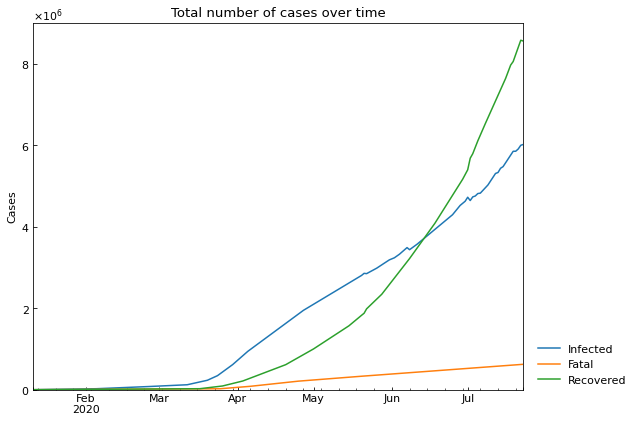

In [10]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [11]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
189,2020-07-18,24862,4516,985,19361
190,2020-07-19,25372,4822,985,19565
191,2020-07-20,25790,5052,987,19751
192,2020-07-21,26421,5284,988,20149
193,2020-07-22,27216,5582,989,20645


In [12]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [13]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
156,2020-07-16,22890,3091,985,18814
157,2020-07-17,23473,3392,985,19096
158,2020-07-18,24132,3781,985,19366
159,2020-07-19,24642,4081,985,19576
160,2020-07-20,25096,4354,985,19757


### Population in each country

In [14]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [15]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
158923,2020-07-19,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158924,2020-07-20,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158925,2020-07-21,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158926,2020-07-22,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158927,2020-07-23,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [16]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Population
807,CZE,Czech Republic,Plzenský kraj,584672
808,COL,Colombia,Bolívar,2070110
809,RUS,Russia,Murmansk oblast,795409
810,RUS,Russia,Republic of Crimea,1913731
811,COL,Colombia,Vichada,107808


In [17]:
population_data.value("Japan", province=None)

126529100

In [18]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
# population_data.value("Japan", province="Tokyo")

### Government Response Tracker (OxCGRT)

In [19]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [20]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
158923,2020-07-19,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158924,2020-07-20,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158925,2020-07-21,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158926,2020-07-22,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
158927,2020-07-23,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [21]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
158923,2020-07-19,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
158924,2020-07-20,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
158925,2020-07-21,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
158926,2020-07-22,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
158927,2020-07-23,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Subset for a country
oxcgrt_data.subset(country="Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
190,2020-07-19,2,0,1,0,0,0,0,3,2,2,1,27.78
191,2020-07-20,2,0,1,0,0,0,0,3,2,2,1,27.78
192,2020-07-21,2,0,1,0,0,0,0,3,2,2,1,27.78
193,2020-07-22,2,0,1,0,0,0,0,3,2,2,1,27.78
194,2020-07-23,2,0,1,0,0,0,0,3,2,2,1,27.78


In [23]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset(iso3="JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
190,2020-07-19,2,0,1,0,0,0,0,3,2,2,1,27.78
191,2020-07-20,2,0,1,0,0,0,0,3,2,2,1,27.78
192,2020-07-21,2,0,1,0,0,0,0,3,2,2,1,27.78
193,2020-07-22,2,0,1,0,0,0,0,3,2,2,1,27.78
194,2020-07-23,2,0,1,0,0,0,0,3,2,2,1,27.78


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [24]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

/mnt/c/Users/takay/Documents/github/covid19-sir/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


/mnt/c/Users/takay/Documents/github/covid19-sir/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


/mnt/c/Users/takay/Documents/github/covid19-sir/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


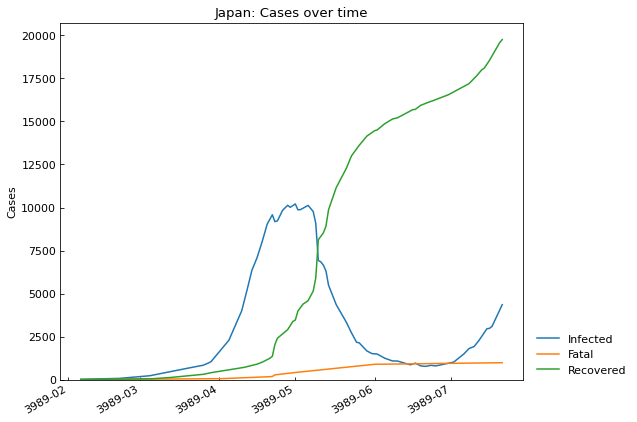

,Date,Confirmed,Infected,Fatal,Recovered
156,2020-07-16,22890,3091,985,18814
157,2020-07-17,23473,3392,985,19096
158,2020-07-18,24132,3781,985,19366
159,2020-07-19,24642,4081,985,19576
160,2020-07-20,25096,4354,985,19757


In [25]:
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

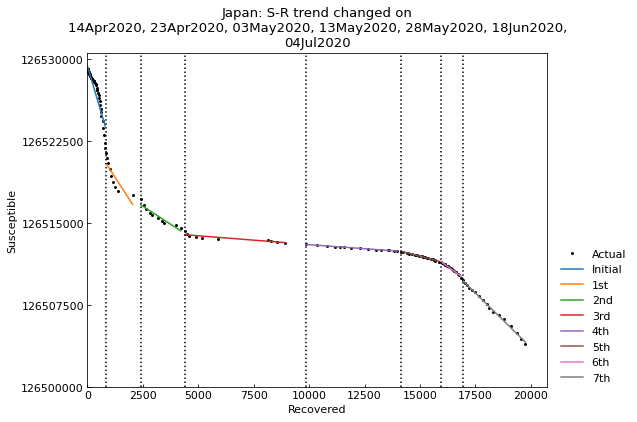

,Type,Start,End,Population
1st,Past,14Apr2020,22Apr2020,126529100
2nd,Past,23Apr2020,02May2020,126529100
3rd,Past,03May2020,12May2020,126529100
4th,Past,13May2020,27May2020,126529100
5th,Past,28May2020,17Jun2020,126529100
6th,Past,18Jun2020,03Jul2020,126529100
7th,Past,04Jul2020,20Jul2020,126529100


In [26]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [27]:
scenario.estimate(cs.SIRF)


<Main scenario: perform parameter estimation>

Running optimization with 8 CPUs...

	7th phase with SIR-F model finished 363 trials in 0 min 55 sec.

	2nd phase with SIR-F model finished 146 trials in 0 min 20 sec.

	1st phase with SIR-F model finished 445 trials in 1 min 1 sec.

	3rd phase with SIR-F model finished 182 trials in 0 min 25 sec.

	4th phase with SIR-F model finished 168 trials in 0 min 20 sec.

	5th phase with SIR-F model finished 87 trials in 0 min 10 sec.

	6th phase with SIR-F model finished 305 trials in 0 min 25 sec.

Completed optimization. Total: 3 min 8 sec

In [28]:
scenario.summary()

,Type,Start,End,Population,ODE,rho,sigma,theta,kappa,tau,Rt,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
1st,Past,14Apr2020,22Apr2020,126529100,SIR-F,0.014584,0.001822,0.019311,0.000048,360,7.65,0.019,5168,17,137,0.125449,445,1 min 1 sec
2nd,Past,23Apr2020,02May2020,126529100,SIR-F,0.007928,0.003299,0.056824,0.000054,360,2.23,0.057,4601,31,75,0.059659,146,0 min 20 sec
3rd,Past,03May2020,12May2020,126529100,SIR-F,0.003122,0.011515,0.060563,0.000301,360,0.25,0.061,830,80,21,0.114003,182,0 min 25 sec
4th,Past,13May2020,27May2020,126529100,SIR-F,0.003761,0.021775,0.453369,0.000079,360,0.09,0.453,3152,66,11,0.105248,168,0 min 20 sec
5th,Past,28May2020,17Jun2020,126529100,SIR-F,0.010895,0.019733,0.024433,0.000786,360,0.52,0.024,317,22,12,0.061687,87,0 min 10 sec
6th,Past,18Jun2020,03Jul2020,126529100,SIR-F,0.024507,0.016421,0.068238,0.001547,360,1.27,0.068,161,10,15,0.093695,305,0 min 25 sec
7th,Past,04Jul2020,20Jul2020,126529100,SIR-F,0.035802,0.016330,0.000855,0.000030,360,2.19,0.001,8339,6,15,0.045005,363,0 min 55 sec


### Accuracy of estimation

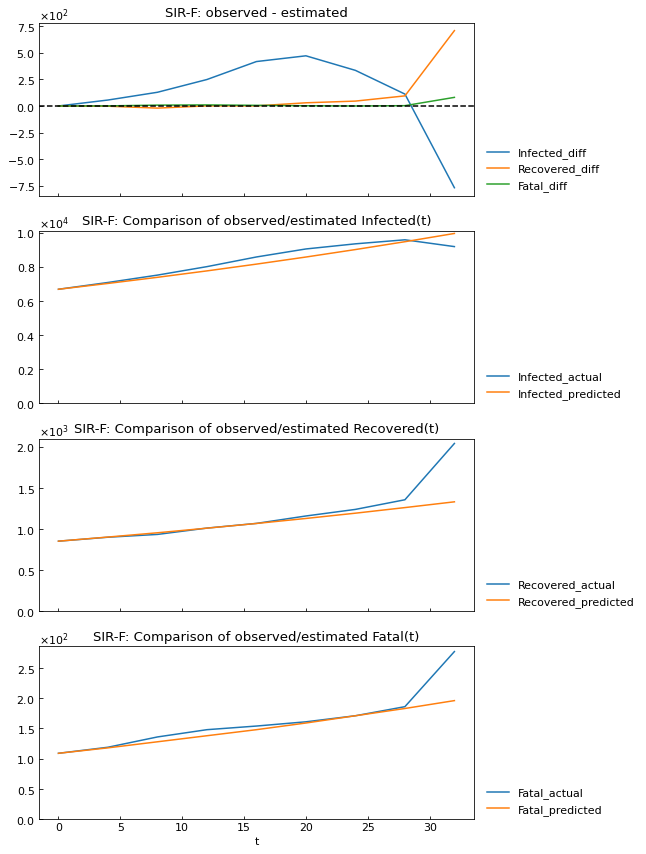

In [29]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [30]:
scenario.get("Rt", phase="4th")

0.09

### Show parameter history

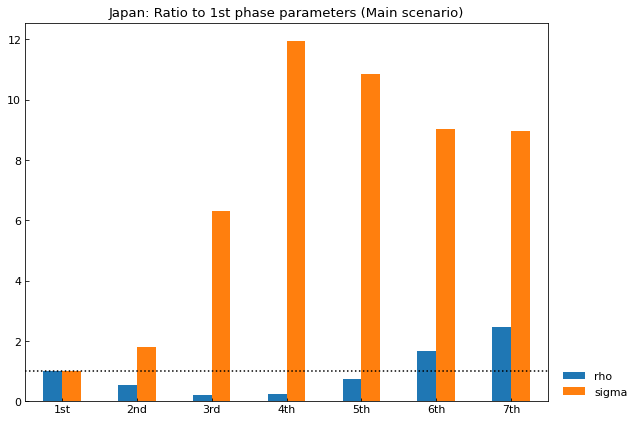

,1st,2nd,3rd,4th,5th,6th,7th
rho,1.0,0.543607,0.214074,0.257896,0.747046,1.680410,2.454883
sigma,1.0,1.811166,6.321330,11.953875,10.833177,9.014903,8.964494


In [31]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

### Show the history of reproduction number

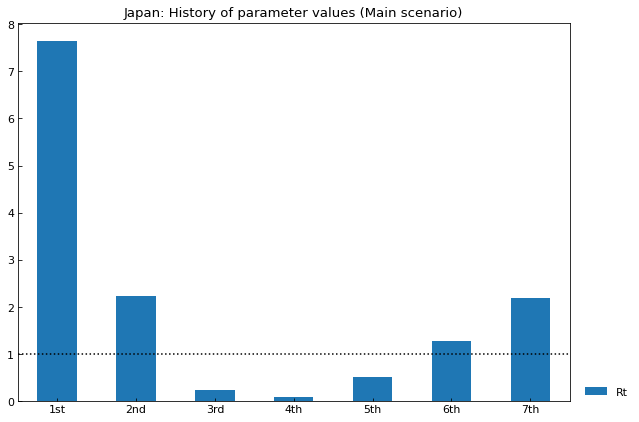

,1st,2nd,3rd,4th,5th,6th,7th
Rt,7.65,2.23,0.25,0.09,0.52,1.27,2.19


In [32]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

### Simulate the number of cases

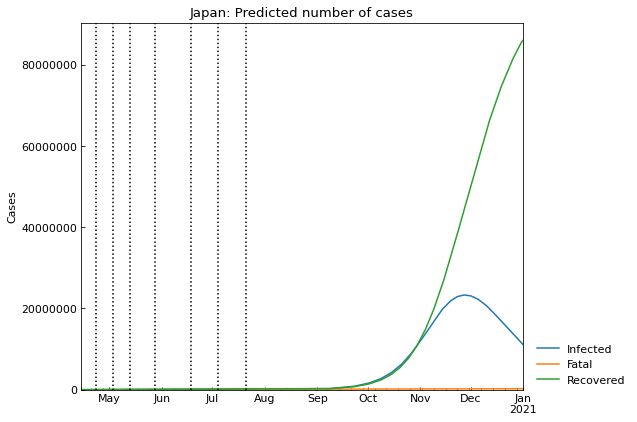

,Date,Fatal,Infected,Recovered,Susceptible
258,28Dec2020,236496,12496638,83262250,30533712
259,29Dec2020,238297,12068957,84067057,30154785
260,30Dec2020,240041,11660655,84844098,29784302
261,31Dec2020,241731,11274482,85594376,29418508
262,01Jan2021,242765,11044565,86051173,29190596


In [33]:
scenario.clear(name="Main")
scenario.add(name="Main", end_date="01Jan2021")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [34]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.01632951511297953

In [35]:
sigma_new = sigma_current * 2
sigma_new

0.03265903022595906

In [36]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE       rho  \
Scenario Phase                                                              
Main     1st      Past  14Apr2020  22Apr2020   126529100  SIR-F  0.014584   
         2nd      Past  23Apr2020  02May2020   126529100  SIR-F  0.007928   
         3rd      Past  03May2020  12May2020   126529100  SIR-F  0.003122   
         4th      Past  13May2020  27May2020   126529100  SIR-F  0.003761   
         5th      Past  28May2020  17Jun2020   126529100  SIR-F  0.010895   
         6th      Past  18Jun2020  03Jul2020   126529100  SIR-F  0.024507   
         7th      Past  04Jul2020  20Jul2020   126529100  SIR-F  0.035802   
         8th    Future  21Jul2020  01Jan2021   126529100  SIR-F  0.035802   
Medicine 1st      Past  14Apr2020  22Apr2020   126529100  SIR-F  0.014584   
         2nd      Past  23Apr2020  02May2020   126529100  SIR-F  0.007928   
         3rd      Past  03May2020  12May2020   126529100  SIR-F  0.003122   
         4th      Past  13May2020  27May2020   126529100  SIR-F  0.003761   
         5th      Past  28May2020  17Jun2020   126529100  SIR-F  0.010895   
         6th      Past  18Jun2020  03Jul2020   126529100  SIR-F  0.024507   
         7th      Past  04Jul2020  20Jul2020   126529100  SIR-F  0.035802   
         8th    Future  21Jul2020  20Aug2020   126529100  SIR-F  0.035802   
         9th    Future  21Aug2020  01Jan2021   126529100  SIR-F  0.035802   

                   sigma     theta     kappa  tau    Rt  alpha1 [-]  \
Scenario Phase                                                        
Main     1st    0.001822  0.019311  0.000048  360  7.65       0.019   
         2nd    0.003299  0.056824  0.000054  360  2.23       0.057   
         3rd    0.011515  0.060563  0.000301  360  0.25       0.061   
         4th    0.021775  0.453369  0.000079  360  0.09       0.453   
         5th    0.019733  0.024433  0.000786  360  0.52       0.024   
         6th    0.016421  0.068238  0.001547  360  1.27       0.068   
         7th    0.016330  0.000855  0.000030  360  2.19       0.001   
         8th    0.016330  0.000855  0.000030  360  2.19       0.001   
Medicine 1st    0.001822  0.019311  0.000048  360  7.65       0.019   
         2nd    0.003299  0.056824  0.000054  360  2.23       0.057   
         3rd    0.011515  0.060563  0.000301  360  0.25       0.061   
         4th    0.021775  0.453369  0.000079  360  0.09       0.453   
         5th    0.019733  0.024433  0.000786  360  0.52       0.024   
         6th    0.016421  0.068238  0.001547  360  1.27       0.068   
         7th    0.016330  0.000855  0.000030  360  2.19       0.001   
         8th    0.016330  0.000855  0.000030  360  2.19       0.001   
         9th    0.032659  0.000855  0.000030  360  1.09       0.001   

                1/alpha2 [day]  1/beta [day]  1/gamma [day]      RMSLE Trials  \
Scenario Phase                                                                  
Main     1st              5168            17            137   0.125449    445   
         2nd              4601            31             75  0.0596586    146   
         3rd               830            80             21   0.114003    182   
         4th              3152            66             11   0.105248    168   
         5th               317            22             12  0.0616874     87   
         6th               161            10             15  0.0936954    305   
         7th              8339             6             15  0.0450049    363   
         8th              8339             6             15          -      -   
Medicine 1st              5168            17            137   0.125449    445   
         2nd              4601            31             75  0.0596586    146   
         3rd               830            80             21   0.114003    182   
         4th              3152            66             11   0.105248    168   
         5th               317            22             12  0.0616874

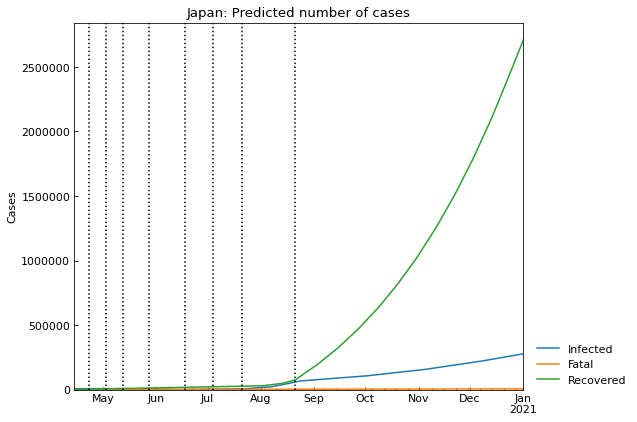

,Date,Fatal,Infected,Recovered,Susceptible
258,28Dec2020,6438,268965,2578349,123675345
259,29Dec2020,6502,271419,2613641,123637534
260,30Dec2020,6568,273883,2649256,123599389
261,31Dec2020,6634,276358,2685195,123560910
262,01Jan2021,6675,277910,2707810,123536703


In [37]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [38]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 01Jan2021,Fatal on 01Jan2021
Main,23319355,27Nov2020,11044565,242765
Medicine,277910,01Jan2021,277910,6675
